# CNN for digits and operators

In [1]:
#load of the datas numbers

In [14]:
import tarfile
import os
import scipy.io
import numpy as np


data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [15]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [16]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

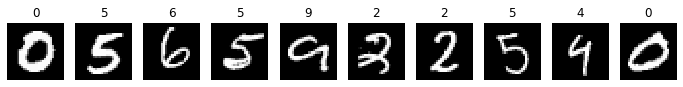

In [17]:
prng = np.random.RandomState(seed=23355553)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
import cv2
import numpy as np
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
import matplotlib.pyplot as plt
import random
from skimage import img_as_ubyte
import os
from skimage.util import random_noise
import joblib

In [21]:
train_images_augmented=[]
for i in train_images:
    train_images_augmented.append(i.tolist())

train_labels_augmented=[]
for i in train_labels:
    train_labels_augmented.append(i)

In [22]:
#load the operators

In [23]:
import cv2

plus = cv2.imread('plus.png')
minus = cv2.imread('moins.png')
divide = cv2.imread('divide.png')
multiply = cv2.imread('multiply.png')
equal = cv2.imread('egal.png')
operators=[plus,minus,divide,multiply,equal]
op=[10,11,12,13,14]
dilat=[np.ones((1,1),np.uint8),np.ones((2,2),np.uint8),np.ones((3,3),np.uint8)]



In [24]:
#convert the pngs of the operators to the right size and shift them to better train our cnn

In [25]:
for i in operators:
    image = cv2.resize(i, (28, 28), interpolation=cv2.INTER_AREA)
    rows,cols=image.shape[:2]
    invert = cv2.bitwise_not(image)
    graym = cv2.cvtColor(invert, cv2.COLOR_BGR2GRAY)
    train_images_augmented.append(graym.tolist())
    for v in dilat:
        image = cv2.resize(i, (28, 28), interpolation=cv2.INTER_AREA)
        image = cv2.dilate(image, v)
        invert = cv2.bitwise_not(image)
        gray = cv2.cvtColor(invert, cv2.COLOR_BGR2GRAY)
        train_images_augmented.append(gray.tolist())
        image = cv2.resize(i, (28, 28), interpolation=cv2.INTER_AREA)
        image = cv2.erode(image, v)
        invert = cv2.bitwise_not(image)
        graym = cv2.cvtColor(invert, cv2.COLOR_BGR2GRAY)
        train_images_augmented.append(graym.tolist())
        for k in range(20):
            M=np.float32([[1, 0, random.randint(-3,3)], [0, 1, random.randint(-3,3)]])
            gray=cv2.warpAffine(gray,M,(cols,rows))
            gray=cv2.warpAffine(graym,M,(cols,rows))
            train_images_augmented.append(gray.tolist())
            train_images_augmented.append(graym.tolist())

In [26]:
for i in op:
    for j in range(1+(((20*2)+2)*len(dilat))):
        train_labels_augmented.append(i)
train_labels_augmented=np.array(train_labels_augmented)

In [27]:
train_images_augmented=np.array(train_images_augmented)

In [28]:
#we train our cnn here

In [29]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils


train_images_augmented =train_images_augmented.reshape((train_images_augmented.shape[0], 28, 28, 1)).astype('float32')
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32')
# normalize inputs from 0-255 to 0-1
train_images_augmented= train_images_augmented / 255
test_images = test_images / 255
# one hot encode outputs
train_labels_augmented= np_utils.to_categorical(train_labels_augmented)
test_labels = np_utils.to_categorical(test_labels)
num_classes = train_labels_augmented.shape[1]
# define the larger model
def larger_model():
	# create model
	model = Sequential()
	model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
	model.add(MaxPooling2D())
	model.add(Conv2D(15, (3, 3), activation='relu'))
	model.add(MaxPooling2D())
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(50, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# build the model
model = larger_model()
# Fit the model
model.fit(train_images_augmented, train_labels_augmented, validation_data=(train_images_augmented, train_labels_augmented), epochs=10, batch_size=200)


Using TensorFlow backend.
C:\Users\JambonEmmental\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\JambonEmmental\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\JambonEmmental\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\JambonEmmental\Anaconda3\lib\site-packages\t

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60635 samples, validate on 60635 samples
Epoch 1/10
60635/60635 [==============================] - 126s 2ms/step - loss: 0.4726 - accuracy: 0.8551 - val_loss: 0.1042 - val_accuracy: 0.9696
Epoch 2/10
60635/60635 [==============================] - 132s 2ms/step - loss: 0.1106 - accuracy: 0.9669 - val_loss: 0.0605 - val_accuracy: 0.9817
Epoch 3/10
60635/60635 [==============================] - 138s 2ms/step - loss: 0.0792 - accuracy: 0.9757 - val_loss: 0.0426 - val_accuracy: 0.9873
Epoch 4/10
60635/60635 [==============================] - 131s 2ms/step - loss: 0.0591 - accuracy: 0.9819 - val_loss: 0.0328 - val_accuracy: 0.9901
Epoch 5/10
60635/60635 [==============================] - 133s 2ms/step - loss: 0.0513 - accuracy: 0.9840 - val_loss: 0.0317 - val_accuracy: 0.9907
Epoch 6/10
60635/60635 [==============================] - 136s 2ms/step - loss: 0.0442 - a

In [30]:
#we load it into a pkl

In [31]:
import joblib
filename = 'digits_cnn2.joblib.pkl'
_ = joblib.dump(model, filename, compress=9)